# Data Science : Tweeter sentiment analysis :

1 - Getting tweets from tweepy, Pre-processing
<br></br>
2 - Displaying topics with LDA
<br></br>
3 - PCA & clustering (Kmeans, CAH, DBscan)
<br></br>


In [1]:
#Package necessary
from textblob import TextBlob
from wordcloud import WordCloud 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from itertools import cycle, islice
from sklearn import metrics
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift, estimate_bandwidth, SpectralClustering
from sklearn.cluster import AgglomerativeClustering, OPTICS, cluster_optics_dbscan, Birch, MiniBatchKMeans
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation as LDA
import warnings
import seaborn as sns
import pandas as pd
import numpy as np
import tweepy
import nltk
import re
import os
import matplotlib.pyplot as plt
warnings.simplefilter("ignore", DeprecationWarning)
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

data = pd.read_csv(os.getcwd()+'/credential.txt', sep="\t", header=None)

#Twitter credentials for the app
consumer_key = data.loc[0,0]
consumer_secret = data.loc[0,1]
access_key= data.loc[0,2]
access_secret = data.loc[0,3]

#pass twitter credentials to tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True)


In [2]:
NoOfTerms = 200
##################################################################### USER ##################################################################### 

userSearch = input("Enter User to search about: ")


posts = api.user_timeline(screen_name = userSearch,count=NoOfTerms, lang="en", tweet_mode="extended")
df = pd.DataFrame( [tweet.full_text for tweet in posts] , columns = ['Tweets'])
df.head(5)
df.shape

##################################################################### SEARCH ##################################################################### 
# =============================================================================
# searchTerm = input("Enter Keyword/Tag to search about: ")
#  
# posts = tweepy.Cursor(api.search, q=searchTerm, lang="en").items(NoOfTerms)
#  
# df = pd.DataFrame([status.text for status in posts], columns = ['Tweets'])
# 
# df.shape
# 
# =============================================================================

Enter User to search about: BillGates


(200, 1)

Targetting the twitter user 'BillGates' as the subject for our analysis

In [3]:
def cleanTxt(text):
    text =  re.sub(r'@[A-Za-z0-9]+', '', text) #Removing  @mentions
    text =  re.sub(r'#', '', text) #Removing the '#' symbol
    text =  re.sub(r'RT[\s]+', '', text) #Removing RT
    text =  re.sub(r'https?:\/\/\S', '', text) #Remove the hyper link    
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub('', text)
    text = text.lower()
    return text

df['Tweets'] = df['Tweets'].apply(cleanTxt)
df.head(5)

,Tweets
0,"melinda recommended i read the choice, i’glad ..."
1,today rednoseday. their work made incredible i...
2,the 1918 influenza outbreak closest comparison...
3,"most conversations days covid-19 stem tide, i’..."
4,"thank conversation partnership, . combating ..."


In [4]:
#Function for subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Function for polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)
df.head(5)

,Tweets,Subjectivity,Polarity
0,"melinda recommended i read the choice, i’glad ...",0.758929,0.196429
1,today rednoseday. their work made incredible i...,0.900000,0.900000
2,the 1918 influenza outbreak closest comparison...,0.761905,0.028571
3,"most conversations days covid-19 stem tide, i’...",0.500000,0.500000
4,"thank conversation partnership, . combating ...",0.316667,0.058333


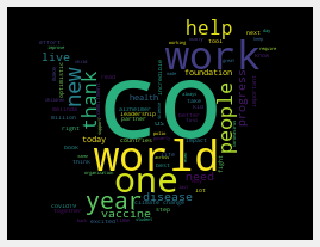

In [5]:
# Displaying the processed word in a wordcloud

twi_mask = np.array(Image.open(os.getcwd()+"/twi.png"))
twi_mask

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
transformed_twi_mask = np.ndarray((twi_mask.shape[0],twi_mask.shape[1]), np.int32)

for i in range(len(twi_mask)):
    transformed_twi_mask[i] = list(map(transform_format, twi_mask[i]))

# word cloud visualization
allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width=500, height=500,mask=transformed_twi_mask, random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud)
plt.axis('off')
plt.show()

In [6]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

df['Analysis'] = df['Polarity'].apply(getAnalysis)
# Show the dataframe
df

,Tweets,Subjectivity,Polarity,Analysis
0,"melinda recommended i read the choice, i’glad ...",0.758929,0.196429,Positive
1,today rednoseday. their work made incredible i...,0.900000,0.900000,Positive
2,the 1918 influenza outbreak closest comparison...,0.761905,0.028571,Positive
3,"most conversations days covid-19 stem tide, i’...",0.500000,0.500000,Positive
4,"thank conversation partnership, . combating ...",0.316667,0.058333,Positive
...,...,...,...,...
195,this something i would loved kid: hosting ser...,0.733333,0.533333,Positive
196,what political economic changes needed address...,0.312500,0.231250,Positive
197,last year invested $92 million networks schoo...,0.133333,0.083333,Positive
198,i recently wrote people tech skills find fasci...,0.370000,0.215000,Positive


In [7]:
# Printing positive tweets 
print('Printing positive tweets:\n')
j=1
sortedDF = df.sort_values(by=['Polarity'])


#Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Analysis'][i] == 'Positive'):
    print(str(j) + ') '+ sortedDF['Tweets'][i])
    print()
    j= j+1


Printing positive tweets:

1) melinda recommended i read the choice, i’glad . i think many people find comfort right dr. edith eva eger'suggestions handle difficult situations. .co/gzeunpsw1w

2) today rednoseday. their work made incredible impact reduce child poverty us around world. .co/4u6jgnzfjq

3) the 1918 influenza outbreak closest comparison ’living right . john barry great job explaining realities lessons devastating pandemic. .co/dg1rkak0in

4) most conversations days covid-19 stem tide, i’also often asked i reading watching. here 2020 summer book recommendations (plus ideas things home). .co/bklfap3nts

5)   thank conversation partnership, . combating pandemic requires global collaboration. india’role key world works minimize social economic impact, pave way vaccine, testing, treatment access . 

6) : when america able get back work? 

the answer depends whether workers caregiving options r…

7) class 2020, easy times. but get . and leadership, world stronger . .co/rypflsale

In [8]:
# Printing negative tweets  
print('Printing negative tweets:\n')
j=1
sortedDF = df.sort_values(by=['Polarity'],ascending=False) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') '+sortedDF['Tweets'][i])
    print()
    j=j+1

Printing negative tweets:

1) halting funding world health organization world health crisis dangerous sounds. their work slowing spread covid-19 work stopped organization replace . the world needs  ever.

2) i always enjoy chatting , even though sit little bit apart usual time. .co/aqwtn1ts2p

3) extreme physical distancing measures make big difference u.s., need consistent nationwide approach. until case numbers start go across america—could take 10 weeks —one continue business usual relax shutdown.

4) science giving us opportunity improve lives around world faster ever . today i honored give speech subject annual meeting. aaasmtg .co/03ywd4svd6

5) : the world must work together slow coronavirus outbreak, protect vulnerable, &amp; develop tools control ep…

6) game ! .co/fhoosavqdc

7) it'great see microsoft'leadership area. avoiding worst effects climate change require innovation investment get us net zero carbon emissions across sectors economy. .co/plejweqdpg

8) i deeply moved t

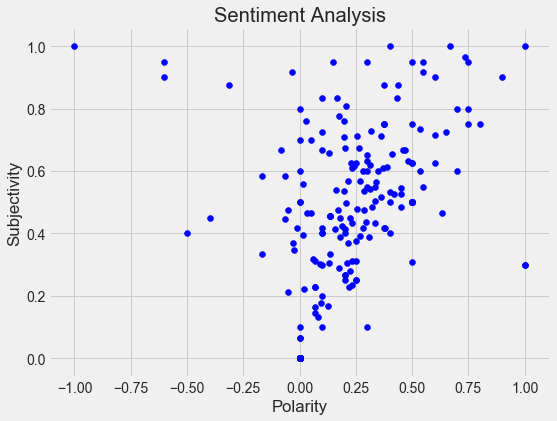

In [9]:
# Plotting 
plt.figure(figsize=(8,6)) 
for i in range(0, df.shape[0]):
  plt.scatter(df["Polarity"][i], df["Subjectivity"][i], color='Blue') 
# plt.scatter(x,y,color)   
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()


In [10]:
#Print the percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']
ptweets

round( (ptweets.shape[0] / df.shape[0]) * 100 , 1)

77.5

In [11]:
# Print the percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']
ntweets

round( (ntweets.shape[0] / df.shape[0]) * 100, 1)


8.5

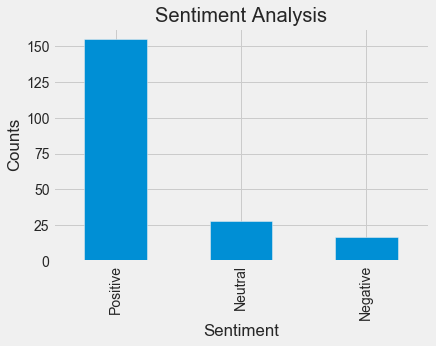

In [12]:
# Show the value counts
df['Analysis'].value_counts()

# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()


In [13]:
#Conversion analysis to numerical labels :
data=df[['Tweets','Analysis']]

classes = np.unique(data['Analysis'])

d=dict(zip(classes,range(0,3)))

dataset = data
dataset['Analysis'] = dataset['Analysis'].map(d, na_action='ignore')
x = dataset['Tweets']
y = dataset['Analysis']
dataset

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Tweets,Analysis
0,"melinda recommended i read the choice, i’glad ...",2
1,today rednoseday. their work made incredible i...,2
2,the 1918 influenza outbreak closest comparison...,2
3,"most conversations days covid-19 stem tide, i’...",2
4,"thank conversation partnership, . combating ...",2
...,...,...
195,this something i would loved kid: hosting ser...,2
196,what political economic changes needed address...,2
197,last year invested $92 million networks schoo...,2
198,i recently wrote people tech skills find fasci...,2


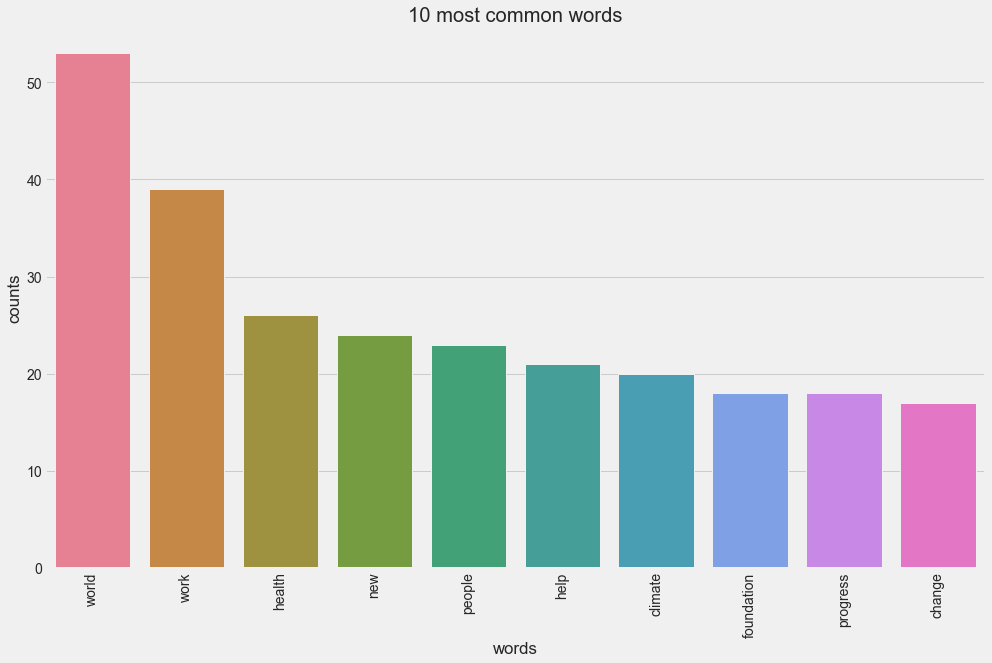

In [14]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(dataset['Tweets'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [15]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
world work health today year vaccines need best foundation leadership

Topic #1:
world work climate like new change people thanks incredible progress

Topic #2:
help change health climate work great need years excited people

Topic #3:
new world foundation optimistic impact make years help people work

Topic #4:
world read alzheimer work progress lives life way disease health


In [16]:
## TOPICS ##
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join(os.getcwd()+'/topics display '+str(number_topics) +'.html')

if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)
            
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, os.getcwd()+'/topics display '+str(number_topics) +'.html')
    


In [17]:
from IPython.display import HTML
x = (os.getcwd()+'/topics display '+str(number_topics) +'.html')
HTML(filename=x)

In [18]:
# Figsize
figsize = (8,8)
point_size = 150
point_border= 1.5


X = count_data.toarray()
Y = dataset.iloc[:,1].values

# Normalize X
mms = MinMaxScaler()
mms.fit(X)
Xnorm = mms.transform(X)
Xnorm.shape


(200, 1518)

### PCA

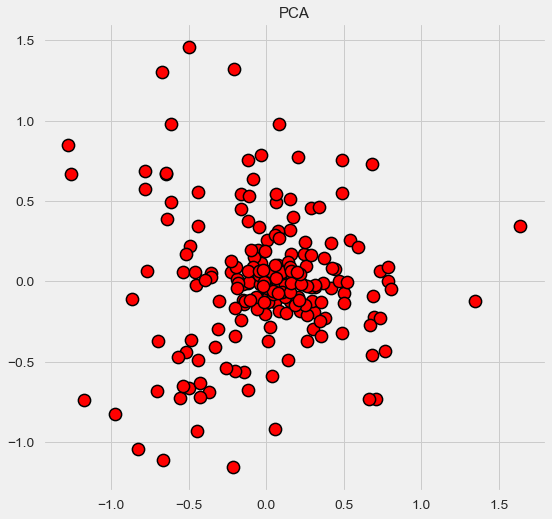

In [19]:
def pca(X, n):
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, dataset[['Analysis']]], axis = 1)
    return principalDf,finalDf

principalDf,finalDf = pca(Xnorm,2)

figsize = (8,8)
point_size = 150
point_border= 1.5

def pc_plot(data, pt_color="red", xlim=None, ylim=None):
    
    plt.figure(figsize=figsize)
    plt.scatter(data['PC1'], data['PC2'],
               s=point_size, color=pt_color,
               edgecolor='black', lw=point_border)
    if xlim != None:
        plt.xlim(xlim)
    if ylim != None:
        plt.ylim(ylim)
    plt.title("PCA")
    plt.show
    
pc_plot(principalDf)


Méthode du coude (cf graphe) : résultat = 3 clusters


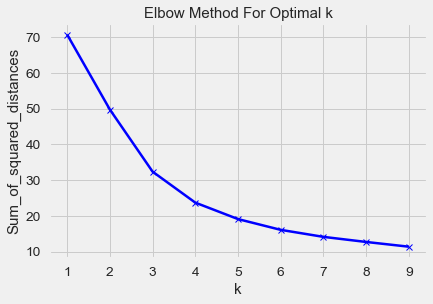

In [20]:
# Detecting the number of clusters
def cluster_detect(dfNoLabels):
    print("Méthode du coude (cf graphe) : résultat = 3 clusters")
    Sum_of_squared_distances = []
    for k in range(1,10):
        km = KMeans(n_clusters=k, init='k-means++')
        km = km.fit(principalDf)
        Sum_of_squared_distances.append(km.inertia_)
           
    plt.plot(range(1,10), Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
cluster_detect(principalDf)

#Let's go with 3

### Kmeans

------------------------------------------------------------
Kmeans résultat
------------------------------------------------------------
Shape: (200, 2)
     Analysis  Cluster
84          2        1
167         2        2
173         1        1
35          2        2
196         2        2


0 2
1 2
2 2
------------------------------------------------------------
K-Means performance
------------------------------------------------------------
Accuracy  0.775
homogeneity_score:  -0.0
completeness_score:  1.0
v_measure_score:  -0.0
adjusted_rand_score:  0.0
adjusted_mutual_info_score:  -0.0


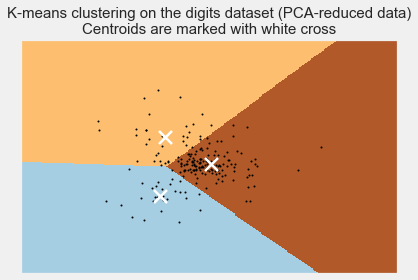

In [21]:
def kmeans(principalDf,NbCluster,finalDf):
    
    kmeans = KMeans(n_clusters=3, init='k-means++').fit(principalDf) 
    KM_clustered = principalDf.copy()
    KM_clustered = pd.DataFrame(KM_clustered)
    KM_clustered.loc[:,'Cluster'] = kmeans.labels_ # append labels to points
    
    frames = [finalDf['Analysis'], KM_clustered['Cluster']]
    result = pd.concat(frames, axis = 1)
    print('-'*60)
    print("Kmeans résultat")
    print('-'*60)
    print("Shape: {}".format(result.shape))
    print(result.sample(5))

    # =============================================================================
    # Assigning a label to each cluster
    # As there's no relation between a cluster number and the true label we need to map a cluster to the one label which appears most in that cluster
    # 
    # These corrected predicted labels are needed below to calculate model performance vs the the true labels
    # =============================================================================
    print('\n')
    for ClusterNum in range(3):
    
        OneCluster = pd.DataFrame(result[result['Cluster'] == ClusterNum].groupby('Analysis').size())
        OneCluster.columns=['Size']
        
        NewDigit = OneCluster.index[OneCluster['Size'] == OneCluster['Size'].max()].tolist()
        NewDigit[0]
    
        rowIndex = result.index[result['Cluster'] == ClusterNum]
        result.loc[rowIndex, 'TransLabel'] = NewDigit[0]
        
        print(ClusterNum, NewDigit[0])
        
    # =============================================================================
    # # Check performance of classification to 3 clusters
    # =============================================================================
    print('-'*60)
    print('K-Means performance')
    print('-'*60)
    
    Correct = (finalDf['Analysis'] == result['TransLabel']).sum()
    Accuracy = round(Correct/finalDf.shape[0],3)
    print('Accuracy ', Accuracy)
    
    # =============================================================================
    # # METRICS for clustering algorithms
    # =============================================================================
    
    print('homogeneity_score: ', round(metrics.homogeneity_score(finalDf['Analysis'], result['TransLabel']),3))
    print('completeness_score: ', round(metrics.completeness_score(finalDf['Analysis'], result['TransLabel']),3))
    print('v_measure_score: ', round(metrics.v_measure_score(finalDf['Analysis'], result['TransLabel']),3))
    print('adjusted_rand_score: ', round(metrics.adjusted_rand_score(finalDf['Analysis'], result['TransLabel']),3))
    print('adjusted_mutual_info_score: ', round(metrics.adjusted_mutual_info_score(finalDf['Analysis'], result['TransLabel']),3))



    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = principalDf.to_numpy()[:, 0].min() - 1, principalDf.to_numpy()[:, 0].max() + 1
    y_min, y_max = principalDf.to_numpy()[:, 1].min() - 1, principalDf.to_numpy()[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')
    
    plt.plot(principalDf.to_numpy()[:, 0], principalDf.to_numpy()[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

kmeans(principalDf, 3, finalDf)


### CAH

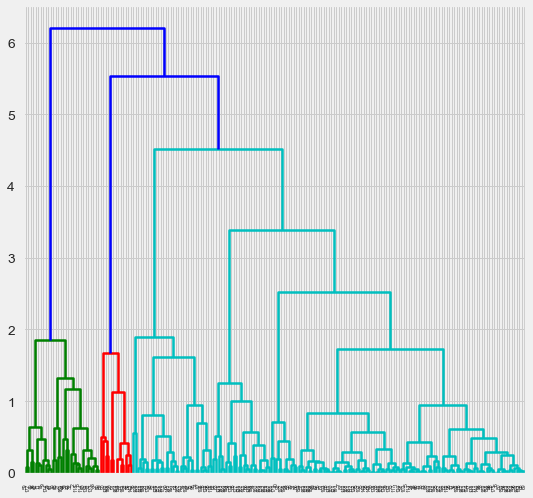

[5 6 1 1 3 6 6 6 1 1 3 1 1 6 3 6 6 6 1 1 2 3 2 5 6 6 6 1 6 1 1 5 1 5 6 3 1
 1 6 1 1 1 1 1 1 1 6 3 3 6 1 3 3 6 4 6 6 6 6 1 3 6 4 4 6 4 4 6 6 6 6 6 3 6
 4 6 3 6 6 5 6 6 6 6 2 6 5 2 6 2 2 2 5 6 3 3 6 6 3 6 6 6 6 6 6 3 3 6 3 6 6
 6 6 6 1 3 6 6 1 6 6 6 6 6 3 4 3 4 6 4 2 6 3 1 4 4 4 6 6 1 6 4 2 4 3 3 6 3
 6 6 6 6 4 6 2 6 2 3 6 6 4 3 4 6 6 2 5 3 6 1 3 3 6 4 1 6 6 1 6 5 6 6 6 2 4
 4 3 6 6 6 4 6 5 6 6 5 4 4 3 6]


In [22]:
def CAH():   

    Z = linkage(principalDf, method='ward', metric='euclidean')
    plt.figure(figsize=(8,8))
    plt.title('')
    dendrogram(Z, labels=principalDf.index, orientation='top', color_threshold=5)
    plt.show()
    

    # decoupage à la hauteur t = 7 ==> identifiants de 3 groupes obtenus
    groupes_cah = fcluster(Z, t=2.5, criterion='distance')
    print(groupes_cah)
    idg = np.argsort(groupes_cah)
    # affichage des observations et leurs groupes
    final_cah = pd.DataFrame(dataset.index[idg], groupes_cah[idg])
    final_cah[:150]

CAH()


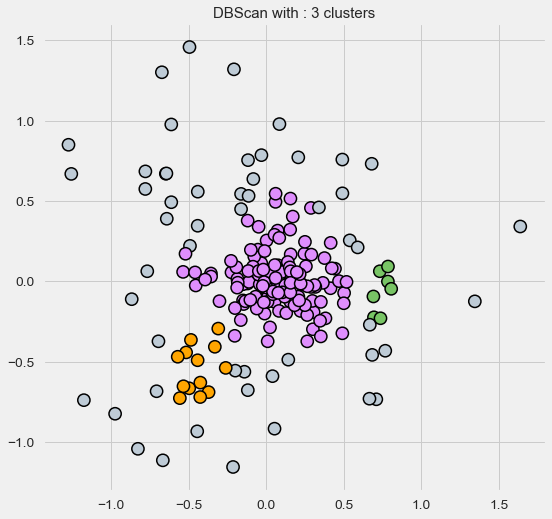

Estimated number of clusters: 3
Estimated number of noise points: 52
None


In [23]:
def dbscan2(dataset, xlim=None, ylim= None,
                           neighborhood=False, epsilon=0.5):
    '''
    Tool to help plot a clustered dataset with the epsilon hyperparameter
    '''

    db = DBSCAN(epsilon).fit(principalDf)
    y_pred = db.fit_predict(principalDf)
        
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_noise_ = list(labels).count(-1)
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = np.array(list(islice(cycle(['#df8efd', '#78c465', 'orange',
                                     '#f65e97', '#a65628', '#984ea3',
                                     '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))
    colors = np.append(colors, '#BECBD6')
    
    
    if neighborhood:
        for point in dataset:
            circle1 = plt.Circle(point, epsilon, 
                                 color='#666666', fill=False, 
                                 zorder=0, alpha=0.3)
            ax.add_artist(circle1)

    ax.scatter(dataset['PC1'], dataset['PC2'], 
               s=point_size, color=colors[y_pred], 
               zorder=10, edgecolor='black', lw=point_border)

    if xlim != None:
        plt.xlim(xlim)
    if ylim != None:
        plt.ylim(ylim)
        
    plt.title('DBScan with : %d clusters' % n_clusters_)
    plt.show()
    
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
print(dbscan2(principalDf, epsilon=0.15))